In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F  
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
import cv2
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split
import sys
import time
from PIL import Image
from torch.optim.lr_scheduler import StepLR, LinearLR
from torch.optim.lr_scheduler import CosineAnnealingLR,SequentialLR
from torchvision.transforms.autoaugment import AutoAugment, AutoAugmentPolicy
from torchsummary import summary

In [2]:
def set_seed(seed=28):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

In [3]:
# 檢查GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using device: %s" % device)
print("You are using PyTorch version: %s" % torch.__version__)

# define class names
classes = ('Class A', 'Class B', 'Class C')

# define the path to the dataset
path_dataset = "/home/NAS/homes/chlunchen-10030/DeepLearning_assignment/competition1/column-classify/dataset_column/column_damage"

You are using device: cuda
You are using PyTorch version: 2.6.0+cu124


In [4]:
from torch.utils.data import Subset, DataLoader
from torchvision.datasets import ImageFolder
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch

# ✅ Class-aware dataset 用於 training
class ClassAwareImageFolder(ImageFolder):
    def __init__(self, root, transform_dict, default_transform=None):
        super().__init__(root)
        self.transform_dict = transform_dict
        self.default_transform = default_transform

    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = self.loader(path)
        sample = np.array(sample)
        transform = self.transform_dict.get(target, self.default_transform)
        if transform:
            augmented = transform(image=sample)
            sample = augmented["image"]
        return sample, target

# ✅ 單一 transform 用於驗證集
class AlbumentationsImageFolder(ImageFolder):
    def __init__(self, root, transform):
        super().__init__(root)
        self.transform = transform

    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = self.loader(path)
        sample = np.array(sample)
        augmented = self.transform(image=sample)
        sample = augmented["image"]
        return sample, target

def load_dataset(path_dataset):
    global classes

    transform_A = A.Compose([
        A.RandomBrightnessContrast(0.3, 0.3, p=0.7),
        A.CLAHE(p=0.3),
        A.Rotate(limit=5, p=0.4),
        A.MotionBlur(blur_limit=3, p=0.2),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.3),
        A.ISONoise(p=0.2),
        A.CoarseDropout(
            max_holes=2,
            max_height=30,
            max_width=30,
            fill_value=0,
            mask_fill_value=None,
            p=0.6
        ),
        A.RandomShadow(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.Resize(224, 224),
        A.Normalize(mean=(0.485, 0.456, 0.406),
                    std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

    transform_B = A.Compose([
        A.Resize(224, 224),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.Sharpen(alpha=(0.1, 0.3), lightness=(0.9, 1.0), p=0.5),
        A.GaussianBlur(blur_limit=(1,3), p=0.2),
        A.ElasticTransform(alpha=1, sigma=50, alpha_affine=20, p=0.2),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

    transform_C = A.Compose([
        A.MotionBlur(blur_limit=3, p=0.2),
        A.HorizontalFlip(p=0.3),
        A.HorizontalFlip(p=0.5),
        A.Resize(224, 224),
        A.Normalize(mean=(0.485, 0.456, 0.406),
                    std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

    transform_test = A.Compose([
        A.Resize(224, 224),
        A.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

    transform_dict = {
        0: transform_A,
        1: transform_B,
        2: transform_C
    }

    raw_dataset = ImageFolder(root=path_dataset)
    classes = raw_dataset.classes

    dataset_size = len(raw_dataset)
    train_size = int(0.75 * dataset_size)
    val_size = dataset_size - train_size
    indices = torch.randperm(dataset_size).tolist()
    train_indices = indices[:train_size]
    val_indices = indices[train_size:]

    # 正確使用 class-aware transform 給 training
    full_dataset_train = ClassAwareImageFolder(
        root=path_dataset,
        transform_dict=transform_dict,
        default_transform=transform_C
    )

    # 單一 transform 給 validation
    full_dataset_val = AlbumentationsImageFolder(
        root=path_dataset,
        transform=transform_test,
        
    )
    
    trainset = Subset(full_dataset_train, train_indices)
    valset = Subset(full_dataset_val, val_indices)

    trainloader = DataLoader(trainset, batch_size=12, shuffle=True, num_workers=4)
    valloader = DataLoader(valset, batch_size=8, shuffle=False, num_workers=4)

    print(f"Dataset classes: {classes}")
    return trainloader, valloader
# Load dataset
trainloader, valloader = load_dataset(path_dataset)

Dataset classes: ['Class A', 'Class B', 'Class C']


In [5]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out
    
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.inplanes = 48
        self.conv1 = nn.Conv2d(3, 48, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(48)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.layer1 = self._make_layer(BasicBlock, 48, blocks=2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 96, blocks=3, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 192, blocks=1, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 384, blocks=1, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(384 * BasicBlock.expansion, 3)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x
'''model_ = ResNet().to(device)'''
from timm import create_model
model_ = create_model('swin_tiny_patch4_window7_224',pretrained=True,num_classes=3).to(device)
model_.to(device)

summary(model_, (3, 224, 224))
print(model_)

/home/chlunchen/.conda/envs/myenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 56, 56]           4,704
         LayerNorm-2           [-1, 56, 56, 96]             192
        PatchEmbed-3           [-1, 56, 56, 96]               0
          Identity-4           [-1, 56, 56, 96]               0
         LayerNorm-5           [-1, 56, 56, 96]             192
            Linear-6              [-1, 49, 288]          27,936
           Softmax-7            [-1, 3, 49, 49]               0
           Dropout-8            [-1, 3, 49, 49]               0
            Linear-9               [-1, 49, 96]           9,312
          Dropout-10               [-1, 49, 96]               0
  WindowAttention-11               [-1, 49, 96]               0
         Identity-12           [-1, 56, 56, 96]               0
        LayerNorm-13             [-1, 3136, 96]             192
           Linear-14            [-1, 31

In [6]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0.001):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_acc):
        if self.best_score is None:
            self.best_score = val_acc
        elif val_acc < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_acc
            self.counter = 0


Train

In [7]:
import copy
class ModelEMA:
    def __init__(self, model, decay=0.99):
        self.ema_model = copy.deepcopy(model)
        self.decay = decay
        self.ema_model.eval()
        for p in self.ema_model.parameters():
            p.requires_grad_(False)

    def update(self, model):
        with torch.no_grad():
            msd = model.state_dict()
            for k, ema_v in self.ema_model.state_dict().items():
                model_v = msd[k].detach()
                if isinstance(ema_v, torch.Tensor):
                    ema_v.copy_(ema_v * self.decay + (1. - self.decay) * model_v)

def train(model, trainloader, valloader, epochs):
    best_val_acc = 0.0
    #class_counts = torch.tensor([348, 156, 210], dtype=torch.float)
    #class_weights = 1.0 / class_counts
    #class_weights = class_weights / class_weights.sum()  # normalize (optional)
    #class_weights = class_weights.to(device)
    class_weights = torch.tensor([1.1, 1, 1.6]).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights,label_smoothing=0.05)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00007, weight_decay=1e-4)
    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs)
    early_stopper = EarlyStopping(patience=5, delta=0.005)
    ema = ModelEMA(model, decay=0.99)
    
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        loop = tqdm(enumerate(trainloader), total=len(trainloader), leave=True)
        for i, data in loop:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            ema.update(model)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss += loss.item()
            loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
            loop.set_postfix(loss=running_loss/(i+1), accuracy=100.*correct/total)

        epoch_train_loss = running_loss / len(trainloader)
        epoch_train_acc = 100. * correct / total
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        ema.ema_model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for data in valloader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = ema.ema_model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        epoch_val_loss = val_running_loss / len(valloader)
        epoch_val_acc = 100. * val_correct / val_total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)
        
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%")
        print(f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%")
        print("-" * 60)

        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            torch.save(ema.ema_model.state_dict(), "best_model.pth")
            print(f"Saved best EMA model with Val Acc: {epoch_val_acc:.2f}%")
        torch.save(ema.ema_model.state_dict(), "final_model.pth")
        scheduler.step()

        '''early_stopper(epoch_val_acc)
        if early_stopper.early_stop:
            print("⛔ Early stopping triggered.")
            break'''
    

    print('Finished Training')
    return ema.ema_model, train_losses, train_accuracies, val_losses, val_accuracies


In [8]:
def evaluate(model, valloader):

    model.eval()
    correct = 0
    total = 0
    
    # Initialize lists for per-class accuracy
    num_classes = len(classes)
    class_correct = list(0. for i in range(num_classes))
    class_total = list(0. for i in range(num_classes))
    
    # Initialize confusion matrix
    confusion_matrix = torch.zeros(num_classes, num_classes)
    
    with torch.no_grad():
        for data in tqdm(valloader, desc="Evaluating"):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Calculate per-class accuracy
            for pred, label in zip(predicted, labels):
                label = label.item()
                pred = pred.item()
                class_correct[label] += int(pred == label)
                class_total[label] += 1
                confusion_matrix[label, pred] += 1

    overall_accuracy = 100 * correct / total
    print(f'Overall Accuracy: {overall_accuracy:.2f}%')

    
    return class_correct, class_total, confusion_matrix
def Save_Model():
    torch.save(model_.state_dict(), 'best_model.pth')
    print("Model saved successfully!")
    return

def Load_Model():
    model_.load_state_dict(torch.load('best_model.pth'))
    model_.eval()
    print("Model loaded successfully!")
    return

In [9]:
print("Starting training...")
#model_.load_state_dict(torch.load("best_model.pth"))
trained_model, train_losses, train_accuracies, val_losses, val_accuracies = train(
    model_, trainloader, valloader, epochs=50)

Starting training...


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch [1/50]: 100%|██████████| 45/45 [00:03<00:00, 12.67it/s, accuracy=75.9, loss=0.602]


Epoch 1/50
Train Loss: 0.6021, Train Acc: 75.93%
Val Loss: 0.7818, Val Acc: 75.42%
------------------------------------------------------------
Saved best EMA model with Val Acc: 75.42%


Epoch [2/50]: 100%|██████████| 45/45 [00:02<00:00, 15.95it/s, accuracy=96.3, loss=0.283]


Epoch 2/50
Train Loss: 0.2832, Train Acc: 96.27%
Val Loss: 0.5313, Val Acc: 84.36%
------------------------------------------------------------
Saved best EMA model with Val Acc: 84.36%


Epoch [3/50]: 100%|██████████| 45/45 [00:02<00:00, 16.22it/s, accuracy=97.9, loss=0.232]


Epoch 3/50
Train Loss: 0.2318, Train Acc: 97.95%
Val Loss: 0.4086, Val Acc: 90.50%
------------------------------------------------------------
Saved best EMA model with Val Acc: 90.50%


Epoch [4/50]: 100%|██████████| 45/45 [00:02<00:00, 15.50it/s, accuracy=98.9, loss=0.209]


Epoch 4/50
Train Loss: 0.2094, Train Acc: 98.88%
Val Loss: 0.3454, Val Acc: 92.74%
------------------------------------------------------------
Saved best EMA model with Val Acc: 92.74%


Epoch [5/50]: 100%|██████████| 45/45 [00:02<00:00, 15.66it/s, accuracy=99.8, loss=0.192]


Epoch 5/50
Train Loss: 0.1923, Train Acc: 99.81%
Val Loss: 0.3065, Val Acc: 95.53%
------------------------------------------------------------
Saved best EMA model with Val Acc: 95.53%


Epoch [6/50]: 100%|██████████| 45/45 [00:02<00:00, 15.76it/s, accuracy=98.9, loss=0.204]


Epoch 6/50
Train Loss: 0.2036, Train Acc: 98.88%
Val Loss: 0.2845, Val Acc: 95.53%
------------------------------------------------------------


Epoch [7/50]: 100%|██████████| 45/45 [00:02<00:00, 15.87it/s, accuracy=99.6, loss=0.191]


Epoch 7/50
Train Loss: 0.1910, Train Acc: 99.63%
Val Loss: 0.2703, Val Acc: 97.21%
------------------------------------------------------------
Saved best EMA model with Val Acc: 97.21%


Epoch [8/50]: 100%|██████████| 45/45 [00:02<00:00, 15.87it/s, accuracy=98.9, loss=0.2]  


Epoch 8/50
Train Loss: 0.2001, Train Acc: 98.88%
Val Loss: 0.2589, Val Acc: 96.65%
------------------------------------------------------------


Epoch [9/50]: 100%|██████████| 45/45 [00:02<00:00, 15.50it/s, accuracy=99.8, loss=0.182]


Epoch 9/50
Train Loss: 0.1821, Train Acc: 99.81%
Val Loss: 0.2429, Val Acc: 97.21%
------------------------------------------------------------


Epoch [10/50]: 100%|██████████| 45/45 [00:02<00:00, 15.52it/s, accuracy=100, loss=0.178]


Epoch 10/50
Train Loss: 0.1785, Train Acc: 100.00%
Val Loss: 0.2492, Val Acc: 97.21%
------------------------------------------------------------


Epoch [11/50]: 100%|██████████| 45/45 [00:02<00:00, 15.28it/s, accuracy=100, loss=0.179]


Epoch 11/50
Train Loss: 0.1791, Train Acc: 100.00%
Val Loss: 0.2599, Val Acc: 96.65%
------------------------------------------------------------


Epoch [12/50]: 100%|██████████| 45/45 [00:02<00:00, 15.59it/s, accuracy=100, loss=0.178]


Epoch 12/50
Train Loss: 0.1778, Train Acc: 100.00%
Val Loss: 0.2693, Val Acc: 96.09%
------------------------------------------------------------


Epoch [13/50]: 100%|██████████| 45/45 [00:02<00:00, 15.74it/s, accuracy=100, loss=0.176]


Epoch 13/50
Train Loss: 0.1760, Train Acc: 100.00%
Val Loss: 0.2709, Val Acc: 96.09%
------------------------------------------------------------


Epoch [14/50]: 100%|██████████| 45/45 [00:02<00:00, 15.71it/s, accuracy=99.4, loss=0.195]


Epoch 14/50
Train Loss: 0.1949, Train Acc: 99.44%
Val Loss: 0.2648, Val Acc: 95.53%
------------------------------------------------------------


Epoch [15/50]: 100%|██████████| 45/45 [00:02<00:00, 15.65it/s, accuracy=99.8, loss=0.184]


Epoch 15/50
Train Loss: 0.1845, Train Acc: 99.81%
Val Loss: 0.2733, Val Acc: 94.41%
------------------------------------------------------------


Epoch [16/50]: 100%|██████████| 45/45 [00:02<00:00, 15.57it/s, accuracy=99.8, loss=0.185]


Epoch 16/50
Train Loss: 0.1851, Train Acc: 99.81%
Val Loss: 0.2802, Val Acc: 94.41%
------------------------------------------------------------


Epoch [17/50]: 100%|██████████| 45/45 [00:02<00:00, 15.70it/s, accuracy=98.7, loss=0.199]


Epoch 17/50
Train Loss: 0.1986, Train Acc: 98.69%
Val Loss: 0.2736, Val Acc: 94.97%
------------------------------------------------------------


Epoch [18/50]: 100%|██████████| 45/45 [00:02<00:00, 15.29it/s, accuracy=99.1, loss=0.194]


Epoch 18/50
Train Loss: 0.1941, Train Acc: 99.07%
Val Loss: 0.3196, Val Acc: 94.97%
------------------------------------------------------------


Epoch [19/50]: 100%|██████████| 45/45 [00:02<00:00, 15.87it/s, accuracy=100, loss=0.182]


Epoch 19/50
Train Loss: 0.1820, Train Acc: 100.00%
Val Loss: 0.3293, Val Acc: 94.97%
------------------------------------------------------------


Epoch [20/50]: 100%|██████████| 45/45 [00:02<00:00, 15.68it/s, accuracy=99.8, loss=0.178]


Epoch 20/50
Train Loss: 0.1777, Train Acc: 99.81%
Val Loss: 0.3268, Val Acc: 94.97%
------------------------------------------------------------


Epoch [21/50]: 100%|██████████| 45/45 [00:02<00:00, 15.77it/s, accuracy=100, loss=0.174]


Epoch 21/50
Train Loss: 0.1735, Train Acc: 100.00%
Val Loss: 0.3282, Val Acc: 94.97%
------------------------------------------------------------


Epoch [22/50]: 100%|██████████| 45/45 [00:02<00:00, 15.47it/s, accuracy=100, loss=0.174]


Epoch 22/50
Train Loss: 0.1740, Train Acc: 100.00%
Val Loss: 0.3236, Val Acc: 94.97%
------------------------------------------------------------


Epoch [23/50]: 100%|██████████| 45/45 [00:02<00:00, 15.58it/s, accuracy=100, loss=0.173]


Epoch 23/50
Train Loss: 0.1728, Train Acc: 100.00%
Val Loss: 0.3181, Val Acc: 94.97%
------------------------------------------------------------


Epoch [24/50]: 100%|██████████| 45/45 [00:02<00:00, 15.96it/s, accuracy=99.8, loss=0.174]


Epoch 24/50
Train Loss: 0.1735, Train Acc: 99.81%
Val Loss: 0.3157, Val Acc: 94.97%
------------------------------------------------------------


Epoch [25/50]: 100%|██████████| 45/45 [00:02<00:00, 15.80it/s, accuracy=100, loss=0.173]


Epoch 25/50
Train Loss: 0.1731, Train Acc: 100.00%
Val Loss: 0.3163, Val Acc: 94.97%
------------------------------------------------------------


Epoch [26/50]: 100%|██████████| 45/45 [00:02<00:00, 15.70it/s, accuracy=100, loss=0.173]


Epoch 26/50
Train Loss: 0.1733, Train Acc: 100.00%
Val Loss: 0.3020, Val Acc: 94.97%
------------------------------------------------------------


Epoch [27/50]: 100%|██████████| 45/45 [00:02<00:00, 16.00it/s, accuracy=100, loss=0.172]


Epoch 27/50
Train Loss: 0.1724, Train Acc: 100.00%
Val Loss: 0.2892, Val Acc: 94.97%
------------------------------------------------------------


Epoch [28/50]: 100%|██████████| 45/45 [00:02<00:00, 15.42it/s, accuracy=100, loss=0.173]


Epoch 28/50
Train Loss: 0.1725, Train Acc: 100.00%
Val Loss: 0.2826, Val Acc: 95.53%
------------------------------------------------------------


Epoch [29/50]: 100%|██████████| 45/45 [00:02<00:00, 15.72it/s, accuracy=99.8, loss=0.179]


Epoch 29/50
Train Loss: 0.1786, Train Acc: 99.81%
Val Loss: 0.2809, Val Acc: 95.53%
------------------------------------------------------------


Epoch [30/50]: 100%|██████████| 45/45 [00:02<00:00, 16.33it/s, accuracy=100, loss=0.173]


Epoch 30/50
Train Loss: 0.1732, Train Acc: 100.00%
Val Loss: 0.2721, Val Acc: 96.09%
------------------------------------------------------------


Epoch [31/50]: 100%|██████████| 45/45 [00:02<00:00, 15.71it/s, accuracy=100, loss=0.172]


Epoch 31/50
Train Loss: 0.1722, Train Acc: 100.00%
Val Loss: 0.2737, Val Acc: 96.09%
------------------------------------------------------------


Epoch [32/50]: 100%|██████████| 45/45 [00:02<00:00, 15.56it/s, accuracy=99.6, loss=0.182]


Epoch 32/50
Train Loss: 0.1824, Train Acc: 99.63%
Val Loss: 0.2896, Val Acc: 96.09%
------------------------------------------------------------


Epoch [33/50]: 100%|██████████| 45/45 [00:02<00:00, 16.25it/s, accuracy=99.8, loss=0.177]


Epoch 33/50
Train Loss: 0.1770, Train Acc: 99.81%
Val Loss: 0.2891, Val Acc: 96.09%
------------------------------------------------------------


Epoch [34/50]: 100%|██████████| 45/45 [00:02<00:00, 15.96it/s, accuracy=99.8, loss=0.175]


Epoch 34/50
Train Loss: 0.1754, Train Acc: 99.81%
Val Loss: 0.2884, Val Acc: 94.97%
------------------------------------------------------------


Epoch [35/50]: 100%|██████████| 45/45 [00:02<00:00, 15.77it/s, accuracy=100, loss=0.173]


Epoch 35/50
Train Loss: 0.1725, Train Acc: 100.00%
Val Loss: 0.2870, Val Acc: 94.97%
------------------------------------------------------------


Epoch [36/50]: 100%|██████████| 45/45 [00:02<00:00, 15.96it/s, accuracy=100, loss=0.172]


Epoch 36/50
Train Loss: 0.1723, Train Acc: 100.00%
Val Loss: 0.2929, Val Acc: 94.41%
------------------------------------------------------------


Epoch [37/50]: 100%|██████████| 45/45 [00:02<00:00, 16.27it/s, accuracy=100, loss=0.172]


Epoch 37/50
Train Loss: 0.1722, Train Acc: 100.00%
Val Loss: 0.2975, Val Acc: 94.41%
------------------------------------------------------------


Epoch [38/50]: 100%|██████████| 45/45 [00:02<00:00, 15.61it/s, accuracy=100, loss=0.172]


Epoch 38/50
Train Loss: 0.1720, Train Acc: 100.00%
Val Loss: 0.3033, Val Acc: 94.41%
------------------------------------------------------------


Epoch [39/50]: 100%|██████████| 45/45 [00:02<00:00, 15.95it/s, accuracy=100, loss=0.172]


Epoch 39/50
Train Loss: 0.1719, Train Acc: 100.00%
Val Loss: 0.3071, Val Acc: 94.41%
------------------------------------------------------------


Epoch [40/50]: 100%|██████████| 45/45 [00:02<00:00, 15.81it/s, accuracy=100, loss=0.172]


Epoch 40/50
Train Loss: 0.1725, Train Acc: 100.00%
Val Loss: 0.3076, Val Acc: 94.41%
------------------------------------------------------------


Epoch [41/50]: 100%|██████████| 45/45 [00:02<00:00, 15.57it/s, accuracy=100, loss=0.174]


Epoch 41/50
Train Loss: 0.1738, Train Acc: 100.00%
Val Loss: 0.3064, Val Acc: 94.97%
------------------------------------------------------------


Epoch [42/50]: 100%|██████████| 45/45 [00:02<00:00, 15.37it/s, accuracy=100, loss=0.172]


Epoch 42/50
Train Loss: 0.1722, Train Acc: 100.00%
Val Loss: 0.3061, Val Acc: 94.97%
------------------------------------------------------------


Epoch [43/50]: 100%|██████████| 45/45 [00:02<00:00, 15.55it/s, accuracy=100, loss=0.172]


Epoch 43/50
Train Loss: 0.1720, Train Acc: 100.00%
Val Loss: 0.3077, Val Acc: 94.97%
------------------------------------------------------------


Epoch [44/50]: 100%|██████████| 45/45 [00:02<00:00, 15.77it/s, accuracy=99.8, loss=0.173]


Epoch 44/50
Train Loss: 0.1732, Train Acc: 99.81%
Val Loss: 0.3054, Val Acc: 94.97%
------------------------------------------------------------


Epoch [45/50]: 100%|██████████| 45/45 [00:02<00:00, 15.53it/s, accuracy=100, loss=0.172]


Epoch 45/50
Train Loss: 0.1716, Train Acc: 100.00%
Val Loss: 0.3019, Val Acc: 94.97%
------------------------------------------------------------


Epoch [46/50]: 100%|██████████| 45/45 [00:02<00:00, 15.96it/s, accuracy=100, loss=0.172]


Epoch 46/50
Train Loss: 0.1716, Train Acc: 100.00%
Val Loss: 0.2994, Val Acc: 94.97%
------------------------------------------------------------


Epoch [47/50]: 100%|██████████| 45/45 [00:02<00:00, 15.81it/s, accuracy=100, loss=0.172]


Epoch 47/50
Train Loss: 0.1718, Train Acc: 100.00%
Val Loss: 0.2984, Val Acc: 95.53%
------------------------------------------------------------


Epoch [48/50]: 100%|██████████| 45/45 [00:02<00:00, 15.63it/s, accuracy=100, loss=0.171]


Epoch 48/50
Train Loss: 0.1714, Train Acc: 100.00%
Val Loss: 0.2978, Val Acc: 95.53%
------------------------------------------------------------


Epoch [49/50]: 100%|██████████| 45/45 [00:02<00:00, 15.83it/s, accuracy=100, loss=0.172]


Epoch 49/50
Train Loss: 0.1721, Train Acc: 100.00%
Val Loss: 0.2975, Val Acc: 95.53%
------------------------------------------------------------


Epoch [50/50]: 100%|██████████| 45/45 [00:02<00:00, 15.86it/s, accuracy=100, loss=0.172]


Epoch 50/50
Train Loss: 0.1717, Train Acc: 100.00%
Val Loss: 0.2972, Val Acc: 95.53%
------------------------------------------------------------
Finished Training


In [10]:
#best_model = ResNet().to(device)
best_model = create_model('swin_tiny_patch4_window7_224', pretrained=False, num_classes=3)
best_model.to(device)
best_model.load_state_dict(torch.load("best_model.pth"))
best_model.eval()

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU(approximate='none')
            (drop1): 

In [11]:
print("Starting evaluating...")
class_correct, class_total, confusion_matrix = evaluate(best_model, valloader)

Starting evaluating...


Evaluating: 100%|██████████| 23/23 [00:00<00:00, 50.22it/s]

Overall Accuracy: 97.21%


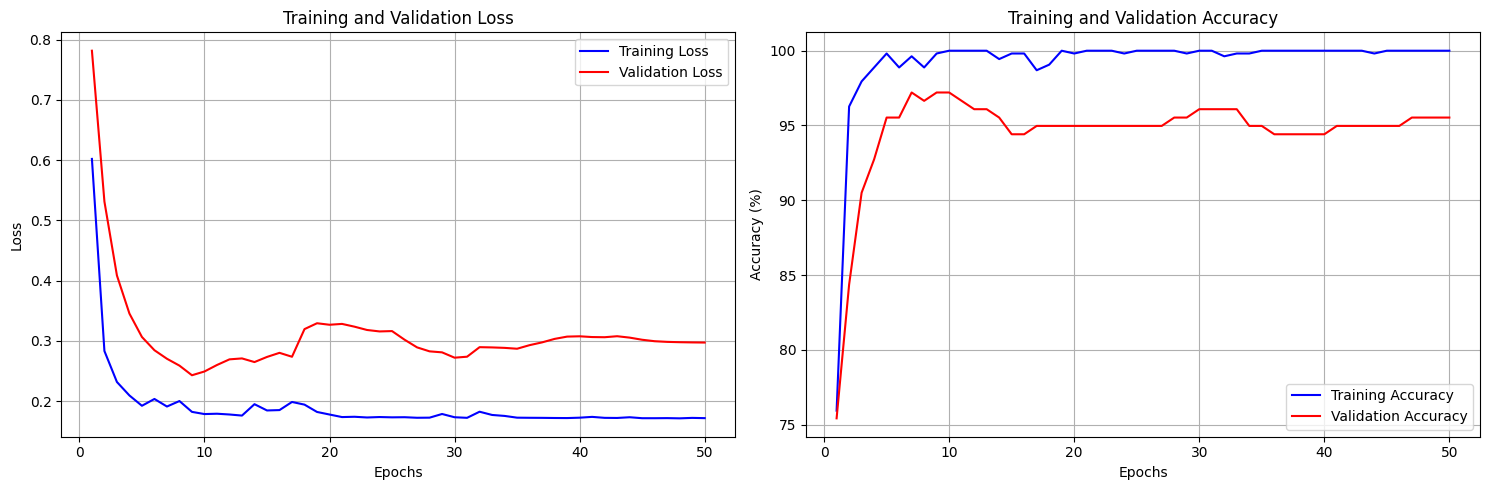

Training metrics plot saved as 'training_metrics.png'

Per-class Accuracy:
--------------------------------------------------
Class A: 97.53% (79/81)
Class B: 100.00% (38/38)
Class C: 95.00% (57/60)


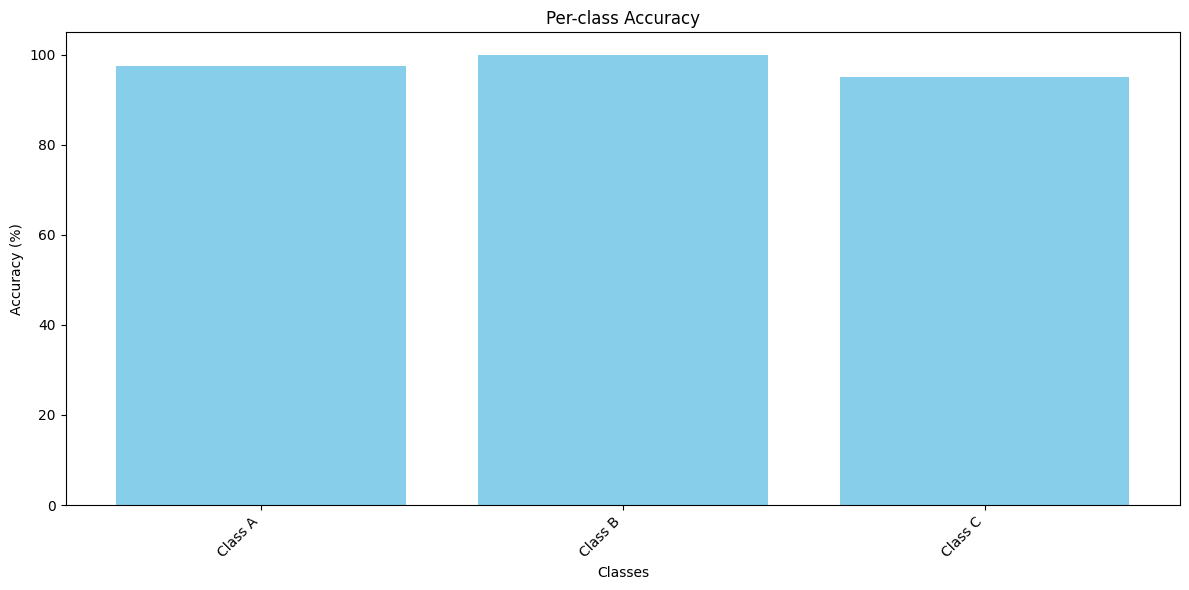

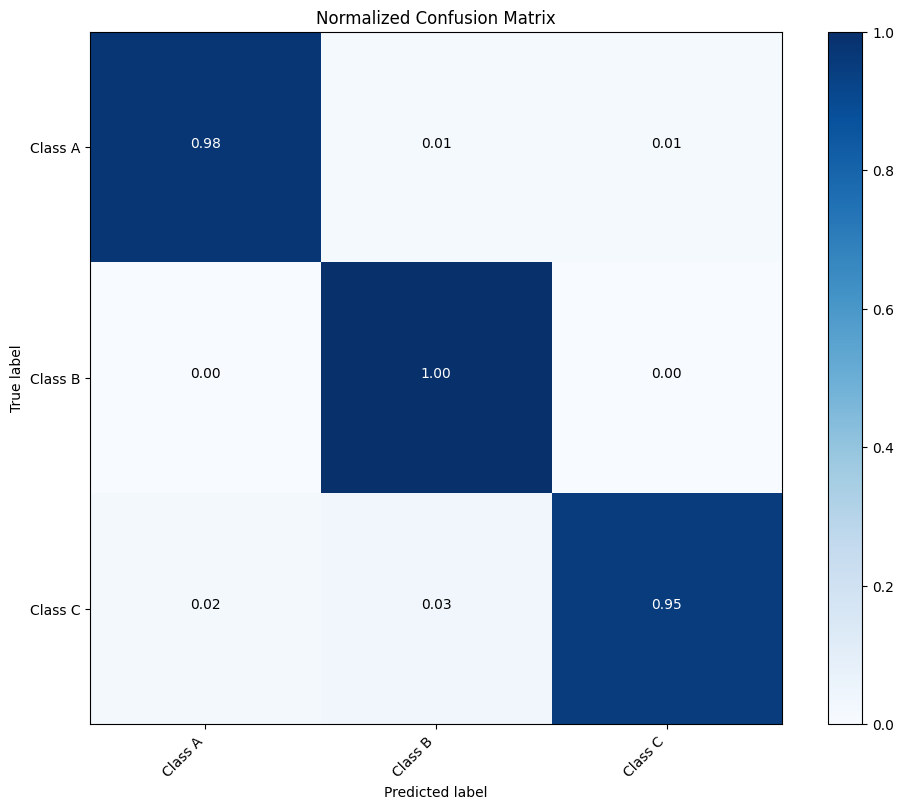

In [12]:
def plot_training_metrics(train_losses, train_accuracies, val_losses, val_accuracies):

    epochs = range(1, len(train_losses) + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(epochs, train_losses, 'b-', label='Training Loss')
    ax1.plot(epochs, val_losses, 'r-', label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
    ax2.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    fig.savefig('training_metrics.png')
    print("Training metrics plot saved as 'training_metrics.png'")
    return
def plot_evaluation_metrics(class_correct, class_total, confusion_matrix):

    num_classes = len(classes)
    
    # Calculate accuracies and identify valid classes
    accuracies = []
    valid_classes = []
    
    print("\nPer-class Accuracy:")
    print("-" * 50)
    for i in range(num_classes):
        if class_total[i] > 0:  # Avoid division by zero
            accuracy = 100 * class_correct[i] / class_total[i]
            print(f'{classes[i]}: {accuracy:.2f}% ({int(class_correct[i])}/{int(class_total[i])})')
            accuracies.append(accuracy)
            valid_classes.append(classes[i])
        else:
            print(f'{classes[i]}: No samples')
    
    # Plot per-class accuracy as a bar chart
    plt.figure(figsize=(12, 6))
    plt.bar(valid_classes, accuracies, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Accuracy (%)')
    plt.title('Per-class Accuracy')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('per_class_accuracy.png')
    plt.show()
    
    # Normalize confusion matrix by row (true labels) and plot
    normalized_confusion_matrix = confusion_matrix.clone()  # Create a copy to avoid modifying the original
    for i in range(num_classes):
        if normalized_confusion_matrix[i].sum() > 0:
            normalized_confusion_matrix[i] = normalized_confusion_matrix[i] / normalized_confusion_matrix[i].sum()
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(normalized_confusion_matrix.cpu().numpy(), interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Normalized Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)
   
    thresh = normalized_confusion_matrix.cpu().numpy().max() / 2.0
    for i in range(num_classes):
        for j in range(num_classes):
            plt.text(j, i, f'{normalized_confusion_matrix[i, j]:.2f}',
                     horizontalalignment="center",
                     color="white" if normalized_confusion_matrix[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png')
    plt.show()
    
    return
plot_training_metrics(train_losses, train_accuracies, val_losses, val_accuracies)
plot_evaluation_metrics(class_correct, class_total, confusion_matrix)

In [13]:
Save_Model()

Model saved successfully!


In [14]:
label_mapping = {
    0: "A",
    1: "B",
    2: "C"}

In [15]:
import os
# Change this part to your path
test_folder_path="/home/NAS/homes/chlunchen-10030/DeepLearning_assignment/competition1/column-classify/dataset_column/test"        
csv_file_path="submission_example.csv"
model_path="best_model.pth"
file_extension=".jpg" 
        
# Load CSV file
df = pd.read_csv(csv_file_path)
print(f"Loaded CSV with {len(df)} entries")

# Get column names
columns = df.columns.tolist()
first_col = columns[0]  # Image name column
second_col = columns[1]  # Empty column for predictions

# Load model
'''model_final = ResNet().to(device)  
model_final.load_state_dict(torch.load(model_path, map_location=device))
model_final.eval()'''
model_final = create_model('swin_tiny_patch4_window7_224', pretrained=False, num_classes=3)
model_final.to(device)
model_final.load_state_dict(torch.load(model_path, map_location=device))
model_final.eval()

# Set up transformation (same as we set up earlier in the dataloaidng part, put I put here again for clarity)
transform = transforms.Compose([
    transforms.Resize([224, 224]),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


for idx, row in tqdm(df.iterrows(), total=len(df)):
    try:
        img_name = str(row[first_col]).strip()
        
        img_path = os.path.join(test_folder_path, img_name + file_extension)
               
        # Process the image
        img = Image.open(img_path).convert('RGB')
        img_tensor = transform(img).unsqueeze(0).to(device)

         
        # Predict
        with torch.no_grad():
            output = model_final(img_tensor)
            _, predicted = torch.max(output.data, 1)
            predicted_idx = predicted.item()
            mapped_label = label_mapping[predicted_idx]
        df.at[idx, second_col] = mapped_label
    except Exception as e:
        print(f"Error with image {img_name}: {e}")

# Save updated CSV
df.to_csv(csv_file_path, index=False)
print(f"Updated CSV saved to {csv_file_path}")


Loaded CSV with 152 entries


100%|██████████| 152/152 [00:01<00:00, 88.21it/s] 

Updated CSV saved to submission_example.csv
